<a href="https://colab.research.google.com/github/RPGILL/carbon-footprint-offset/blob/main/Copy_of_Comparative_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comparative Evaluation: (Comparing Two Models for Legal Citation Labels)

In [ ]:
from google.colab import files, pathlib    # load the Colab file upload and it also try to load pathlib.
uploaded = files.upload()   # it start a file picker and selected legal+case+reports.zip and selected file is uploaded


Saving legal+case+reports.zip to legal+case+reports.zip


In [ ]:
import os, shutil, glob    # os it create folders and it list files , shutil move/copy files and glob locate files by pattern which not used
os.makedirs("data", exist_ok=True)    # it create the data folder and if it already exists do not take no action.
for name in uploaded:    # check the names of each uploaded file.
    if name.endswith(".zip"):     # only do something when the file ends in zip.
        shutil.move(name, f"data/{name}")   # it Place the zip file in the data folder and f"data/{name}" creates the path data file.zip.
!ls -lh data      # shell command list the files in data and  -l  long list and  -h sizes that which human can read



total 81M
-rw-r--r-- 1 root root 81M Nov 11 10:08 legal+case+reports.zip


In [ ]:
!pip install -q pandas numpy scikit-learn matplotlib sentence-transformers tqdm     # install the needed Python libraries


DATASET

This project addressed ciation function classification in legal case reports ,every case is in xml file. inside the file there are <citiation> items . every ciation got a small txt and label which tell you how the earlier case was found . I turned this into a multiclass txt classification task. well the goal is to read the ciation txt and predict the label .I focused 7most common label which is cited,referred to,applied,followed ,considered ,discussed,distinguished. An nlp system is needed because recognising whether an authority is merely cited or substantively applied,followed,distinguished . the whole dataset got large ciation txt from case files and the clases are not balanced like cited is much bigger than the others so because of this I use marco-f1 so that every class counts equally. This problem matters because lawyer and students need to know quickly if a case was just named or if it was applied ,followed,disntinguished that tell how strong the support is .I kept the capital letters and punchation because they matter in the legal writing (party name,brackets,neutral ciation. I parsed the xml clean spaces, remove empty rows and split data 64%train,16%validation,20% test.

In [ ]:
import re, zipfile, os    # re  it locate patterns in the text and zipfile  open files in zip format and os work with files and paths
import pandas as pd      # pandas tables
import matplotlib.pyplot as plt    # plots
from collections import Counter   # it counts things

ZIP_PATH = "data/legal+case+reports.zip"     # where the zip file is
assert os.path.exists(ZIP_PATH), "Put legal+case+reports.zip in ./data/"    # it Stop and display the message if the file is not there.


with zipfile.ZipFile(ZIP_PATH) as zf:   # 'zf'is to open the zip file.
    xml_files = [n for n in zf.namelist() if n.lower().endswith(".xml")]      # it make a list of file names in the zip and go through every name in the zip and Only names ending in xml will be taken.
    print("Total XML files:", len(xml_files))     # it  print how many XML files found

    sample = zf.read(xml_files[0]).decode("utf-8", errors="ignore")    # it read the first byte of an XML file and turn bytes into text and  ignore bad characters
    print(sample[:1500])     #it  print the first 1500 characters


Total XML files: 10534
<?xml version="1.0"?>
<case>
<name>Sharman Networks Ltd v Universal Music Australia Pty Ltd [2006] FCA 1 (5 January 2006)</name>
<AustLII>http://www.austlii.edu.au/au/cases/cth/FCA/2006/1.html</AustLII>
<citations>
<citation "id=c0">
<class>cited</class>
<tocase>Universal Music Australia Pty Ltd v Sharman License Holdings Ltd (2005) 220 ALR 1</tocase>
<text>2 Wilcox J delivered judgment on the complex issues of liability arising in the primary proceedings on 5 September 2005 ( Universal Music Australia Pty Ltd v Sharman License Holdings Ltd (2005) 220 ALR 1). In the meantime, Ms Hemming had filed two disclosure affidavits pursuant to Wilcox J's orders of 22 March 2005 whilst Sharman License and Sharman Networks had unsuccessfully sought several stays on various grounds of that same order insofar as it applied to them (see Universal Music Australia Pty Ltd v Sharman License Holdings Ltd [2005] FCA 406 per Hely J, delivered 8 April 2005; Universal Music Australia P

In [ ]:
#  parse dataset
def parse_citations(xml_str, keep_labels=None):   # it  Create a function and input text in XML format. Labels to to be there are optional.
   # If  XML is different change the tag names
    citation_blocks = re.findall(r"<citation.*?>.*?</citation>", xml_str, flags=re.DOTALL|re.IGNORECASE)    # find every <citation> and </citation> block in the xml text which matches across lines and ignore case
    rows = []   # it begin a blank list of text and label pairs
    for block in citation_blocks:     # it  go through each citation block
        label_m = re.search(r"<class>(.*?)</class>", block, flags=re.DOTALL|re.IGNORECASE)  # it  Look for the label inside <class>... </class>
        text_m  = re.search(r"<text>(.*?)</text>", block,  flags=re.DOTALL|re.IGNORECASE)  # it Look for the citation text inside <text>... </text>
        if not (label_m and text_m):    # if  part is missing it skip this block
            continue
        label = label_m.group(1).strip().lower()   # it get the label text and  trim spaces make lowercase.
        text  = re.sub(r"\s+", " ", text_m.group(1).strip())   # it extract the text of the citation remove spaces and condense a lot of spaces into one.
        if text and (keep_labels is None or label in keep_labels):  # it Save text label and  if  text and either no filter or label is in the filter.
            rows.append((text, label))       # it give back the list of text and  label
    return rows

#  it count label frequencies over the  all XML
label_counts = Counter()   # it  make a counter for labels
with zipfile.ZipFile(ZIP_PATH) as zf:     # it open the zip file
    for name in xml_files:    # its like for each XML file name  found earlier
        xml = zf.read(name).decode("utf-8", errors="ignore")      # it read the file bytes from the zip and  turn to text
        for lab in re.findall(r"<class>(.*?)</class>", xml, flags=re.DOTALL|re.IGNORECASE): # well each <class>... </class> in this document
            lab = lab.strip().lower()     # it clean the spaces and make the lowercase
            if lab: label_counts[lab] += 1   # it add 1 to the counter and for this label

print("Top labels:", label_counts.most_common(15))     # it shows the 15 most common labels and their counts

# Keep the 7 most common or tune number if needed
keep_labels = [l for l, _ in label_counts.most_common(7)]  # it make a list of just the label names not the counts for the top 7 labels
keep_labels      # it show the list so it can see what kept


Top labels: [('cited', 12230), ('referred to', 4392), ('applied', 2557), ('followed', 2290), ('considered', 1725), ('discussed', 1056), ('distinguished', 626), ('quoted', 127), ('affirmed', 113), ('related', 113), ('approved', 110), ('notfollowed', 70), ('reversed', 26), ('explained', 20), ('questioned', 16)]


['cited',
 'referred to',
 'applied',
 'followed',
 'considered',
 'discussed',
 'distinguished']

In [ ]:
#  dataset build
rows = []   # it make an empty list to store text and  label pairs
with zipfile.ZipFile(ZIP_PATH) as zf:    # it open the zip file as zf
    for name in xml_files:   # it go through each XML file name in the zip.
        xml = zf.read(name).decode("utf-8", errors="ignore")
        rows.extend(parse_citations(xml, set(keep_labels)))    # it read that XML file from the zip bytes and turn it into text.

df = pd.DataFrame(rows, columns=["text", "label"])   # it find all text label pairs inside this XML and keep only labels in keep_labels
print(df.shape)   # it make a table DataFrame with two columns text and label  and  print how many rows and columns the table has should be N, 2
df.head()    #  it show the first few rows to check it looks right


(24447, 2)


,text,label
0,2 Wilcox J delivered judgment on the complex i...,cited
1,2 Wilcox J delivered judgment on the complex i...,cited
2,2 Wilcox J delivered judgment on the complex i...,cited
3,2 Wilcox J delivered judgment on the complex i...,cited
4,2 Wilcox J delivered judgment on the complex i...,cited


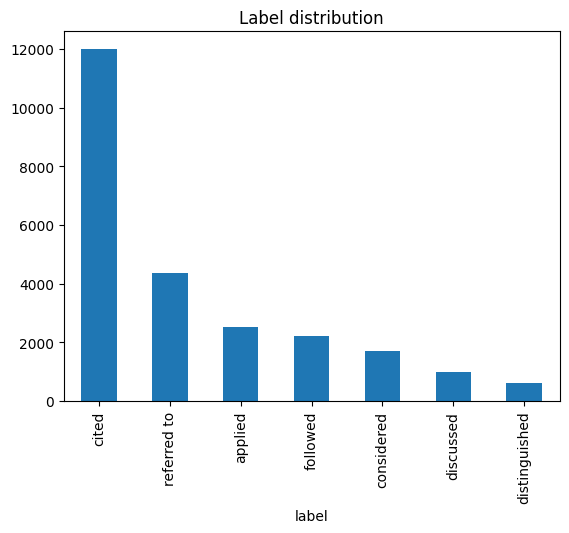

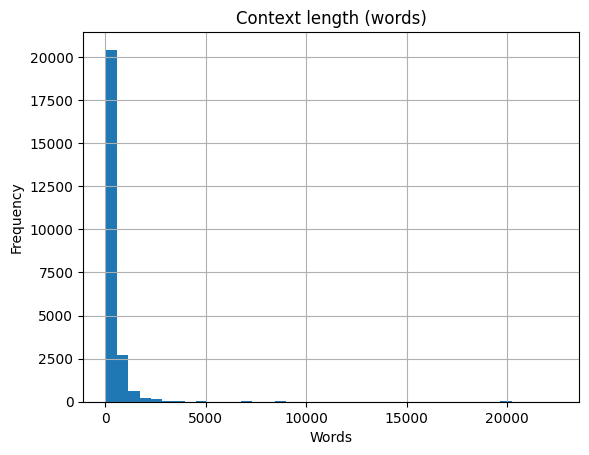

,count
label,
cited,12002
referred to,4365
applied,2526
followed,2231
considered,1699
discussed,1004
distinguished,620


In [ ]:
# EDA data checks
ax = df["label"].value_counts().plot(kind="bar", title="Label distribution")  # it counts how many rows for each label and raw a bar chart of those counts and save the chart object in ax
plt.show()   # it  shows the bar chart

df["n_words"] = df["text"].str.split().str.len()   # it make a new column called n_words and split each text into words it count them and store the count .
df["n_words"].hist(bins=40)  # it draws a histogram of n_words and use 40 bins 40 bars
plt.title("Context length (words)")   # it set the chart title
plt.xlabel("Words"); plt.ylabel("Frequency")  # this set x-axis label to Words
plt.show()   # it shows the histogram

df["label"].value_counts()   # this print the counts for each label again as the numbers


Representation Learning

I used two different ways to turn the txt to numbers . I first build sparse TF–IDF features, this include word n-grams (1-20) and character n-grams (3–5). They keep case in the purpose word n-grams chatches clues like applied, followed and fixed legal phrases. Character n-gram catches subword patterns like neutral citations ,brackets , section numbers and punctuation. Td-idf reduces the weight of common items and lifts rare helpful ones . And then I used dense sentence embeddings from pre-trained all-MiniLM-L6-v2 model . it turns each context to one vector that try to capture whole meaning not just the exact words. I kept the encoder frozen and trained small classifier on top. These two choices lets compare lexical versus semantic signals . in this data many clues are surface based so sparse features can work well but when the wording changes or its paragraphed embedding may work better . I didnt do big normalization because capitals , punctuation and party names may matter in law. This sets a baseline tf-idf and an alternative with embedding so the results show effect of representation not just the parameters .


In [ ]:
from sklearn.model_selection import train_test_split   # stuff to divide the data into separate

SEED = 42  # it fixis the random seed to ensure that the split is consistent each time
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["label"], random_state=SEED)   # the full table and  20% goes to TEST and use the fixed seed and keep the same label mix in each split.
train_df, val_df  = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=SEED)  # it result train_df 80%, test_df 20%

X_train, y_train = train_df["text"].tolist(), train_df["label"].tolist()   # it split the current train part again and  20% of TRAIN becomes VALIDATION and keep label mix.
X_val,   y_val   = val_df["text"].tolist(),   val_df["label"].tolist()  # this result train_df 64% of all data and val_df 16% of all data  because 20% of the original 80% = 16%
X_test,  y_test  = test_df["text"].tolist(),  test_df["label"].tolist()   # it test inputs and the labels

len(train_df), len(val_df), len(test_df), sorted(df["label"].unique())  # this shows how many rows are in train, val, test  and list all unique labels sorted to double-check classes


(15645,
 3912,
 4890,
 ['applied',
  'cited',
  'considered',
  'discussed',
  'distinguished',
  'followed',
  'referred to'])

In [ ]:
# TF–IDF vectorisers word + char to be used
from sklearn.feature_extraction.text import TfidfVectorizer   #  that turns text into TF-IDF numbers
from sklearn.pipeline import FeatureUnion   #  this joins two feature makers into one

word_vect = TfidfVectorizer(
    ngram_range=(1,2),  # it use 1-word and 2-word chunks
    min_df=2,      # this ignore words that appear in only 1 doc
    max_df=0.95,   # this ignore very common words (top 5%)
    lowercase=False  # it keep case for legal signals
)
char_vect = TfidfVectorizer(
    analyzer="char",      # it works on characters not words
    ngram_range=(3,5),     # this use 3, 4, and 5 character chunks
    min_df=2         # ignore character chunks seen only once
)       # this makes TF-IDF features from CHARACTER n-grams
tfidf_union = FeatureUnion([("word", word_vect), ("char", char_vect)])     # it join the word features and the char features into one big feature set and output  TF-IDF words | TF-IDF chars


In [ ]:
# Sentence-transformer embeddings function
import numpy as np      # numpy fast number arrays
try:         # this try to run this block
    from sentence_transformers import SentenceTransformer        # import the tool that makes sentence embeddings
    st_model = SentenceTransformer("all-MiniLM-L6-v2")        # load the MiniLM model it may download once
    def embed(texts, batch_size=256):       # this make a function named embed and input a list of texts and batch_size how many texts to encode at once bigger equals faster and uses more RAM
        return np.asarray(st_model.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True))     # this texts to turn into vectors and encode in batches and  show a progress bar and return numpy arrays
    USE_ST = True        # it output a numpy array of embeddings one vector per text and mark that embeddings are available
except Exception as e:     # if anything above fails like no package, no internet
    print("Sentence-Transformers not available:", e)     # it tells the user it did not work and show the error
    USE_ST = False        # this mark that embeddings are NOT available so we can skip this


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Algorithms


What I did is I compared 2 different methods which are completely different and every method matches 1 representation from previous section. what I want to do is to see which mix of features and classifiers for best for this legal task and why so I use . 1 linear support vector machine (SVM) with TF–IDF n-grams . linear svm try to draw straight lines that separate clasess with the bigist margin. Txt problem with lots of features this idea works very well, I use one-vs-rest setup this model learn 1 classifier for each label and at the prediction time pick the label with the largest score. The loss function is a hinge loss with l2 regulation which is controlled by c and a smaller c means strong regulation and wider margins. larger c fits the trafning data more closely , because tf-idf features already encode usefujl scalling so no need for more normalisation. Another benefit is interpretability the svm gives a weight for every n-gram and the highest positive weight show which word or character pattern push the model toward each class. the top n-grams most of time matches human expectation in law like presence of applied, followed or phrasing that signals a distinction.
2 .multinomial logistic regression on frozen sentence embeddings. sentence transformer model like all-MiniLM-L6-v2 turn a text into a dense vector and nearby vectors ment to have a similer meaning . so I freeze the encoder to keep things simple and fast and on the top of embedding I trained multinomial logistic regression classifer which estimate class possibilities using a softmax over linear scores and minmises crossentropy loss. When comparing with svm margin view logistic regression is problematic so its outputs can be read as confidence scores because the feature are small dense vector. the classifer has very few parameters and trained quickly. For validation, tuning and fair testing I choose setting using five fold stratified cross-validation on the training data and select by macro F1. Marco f1 treats all the clasees equally and is very good with imbalanced data. For SVM I tune C in (0.5, 1.0, 2.0) and for Logistic Regression I tune C on the same values and use the LBFGS solver in multinomial mode. The dataset is unbalanced with many cited examples so these choices help avoid a biased model. So I keep case and punctuation and include character n-grams because brackets,numbers and citation formats may have  meaning in legal writing stuff. I think think tf-idf svm do well when surface word are strong signels , it should pick up markers referred, applied,followed or recurring character shapes in citations. Embedding might help when same idea is written in different words. When finish training I check svm top n-grams per class for human readable clues and for embedding model I learn per-class precision and recall  F1 and confusion matrices because single features are not directly readable.


In [ ]:
from sklearn.pipeline import Pipeline      # it chains the steps together and features to model
from sklearn.svm import LinearSVC     # the SVM classifier linear
from sklearn.model_selection import GridSearchCV, StratifiedKFold      # GridSearchCV equals try many settings to find the best and StratifiedKFold equal to split data into folds and keep label ratios
from sklearn.metrics import f1_score, accuracy_score, classification_report    # it functions to measure how good the model is

svm_pipe = Pipeline([     # first step make TF-IDF features word + char
    ("vec", tfidf_union),
    ("clf", LinearSVC(random_state=SEED))   #  train a Linear SVM on those features
])

svm_param_grid = {"clf__C": [0.5, 1.0, 2.0]}     # svm_pipe equalls the full pipeline and list of C values to try for the SVM and note clf__C means parameter C inside the clf step.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)    # it makes 5 folds for cross-validation and shuffle rows, keep label ratios and use fixed seed

svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid,      # the pipeline made and the C values to try
    scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1     # score equalls macro-F1 treat all labels equally and print progress fits count etc. svm_grid will train many models and pick the best one
)
svm_grid.fit(X_train, y_train)     # it run the grid search and for each C value it do 5-fold CV and keep the best by macro-F1

print("Best SVM params:", svm_grid.best_params_) # it show which C was best
print("CV Macro-F1:", svm_grid.best_score_)  # it show the mean macro-F1 across the 5 folds for that best C
svm_best = svm_grid.best_estimator_   # this get the best pipeline features with SVM with the best C.

y_val_pred_svm = svm_best.predict(X_val) # this use the best model to predict labels for the validation texts
print("Validation (SVM) Acc:", accuracy_score(y_val, y_val_pred_svm))   # it print validation accuracy percent correct
print("Validation (SVM) Macro-F1:", f1_score(y_val, y_val_pred_svm, average="macro"))  # this print validation macro-F1 average F1 over all labels and equal weight


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best SVM params: {'clf__C': 2.0}
CV Macro-F1: 0.42535187538594627
Validation (SVM) Acc: 0.6060838445807771
Validation (SVM) Macro-F1: 0.45837708457665377


In [ ]:
from sklearn.linear_model import LogisticRegression     # the Logistic Regression model
from sklearn.model_selection import GridSearchCV   # this try many settings and pick the best grid search

if USE_ST:      # this only run if sentence embeddings are ready
    X_train_emb = embed(X_train)    # it turn train texts into embedding vectors
    X_val_emb   = embed(X_val)   # turn validation texts into vectors
    X_test_emb  = embed(X_test)    # turn test texts into vectors

    base_lr = LogisticRegression(max_iter=2000, multi_class="multinomial", solver="lbfgs", n_jobs=-1)    # it allows more steps to converge and optimisation method and use all CPU cores
    lr_grid = GridSearchCV(    # this handle many classes at once
        base_lr, param_grid={"C": [0.5, 1.0, 2.0]},    # the model to tune and try these C values . score by macro-F1 treat classes equally
        scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1     # use the same 5-fold stratified CV and use all CPU core and  print progress
    )
    lr_grid.fit(X_train_emb, y_train)   # run the grid search and train many models on the embeddings and pick the best C

    print("Best LR params:", lr_grid.best_params_)    # it shows which C was best
    print("CV Macro-F1:", lr_grid.best_score_)   # show the cross-validation macro-F1 of that best model
    lr_best = lr_grid.best_estimator_    # get the best Logistic Regression model with best C

    y_val_pred_lr = lr_best.predict(X_val_emb)    #it predict labels for the validation vectors
    print("Validation (LR) Acc:", accuracy_score(y_val, y_val_pred_lr))    # print validation accuracy
    print("Validation (LR) Macro-F1:", f1_score(y_val, y_val_pred_lr, average="macro"))    # print validation macro-F1
else:
    print("Pipeline B skipped (sentence-transformers not available).")    # if embeddings are not set up this skip this and print a message


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LR params: {'C': 2.0}
CV Macro-F1: 0.13018349892278314
Validation (LR) Acc: 0.48287321063394684
Validation (LR) Macro-F1: 0.12552460971093934


evalution

64% train,16% validation and 20% test so each split keeps the same label ratios. I pick hyper-parameters with five-fold stratified cross-validation on the training set using macro F1. It gives each label equal weight which is important because the data is imbalanced it averages F1 scores over all labels so small classes like distinguished still matter. After choosing settings on validation I refit on train plus validation and report results on the held-out test set. it show accuracy macro F1 per-class precision recall F1and confusion matrices for both. TF–IDF  Linear SVM
Accuracy = 0.621, Macro-F1 = 0.468. It predicts cited  well and does a reasonable job on the other labels referred to , followed, and applied. The confusion matrix shows most mistakes happen between similar labels like applied vs cited which is understandable.
Embeddings  Logistic Regression
Accuracy = 0.485, Macro-F1 = 0.125. It predicts cited too often and misses many smaller classes because of this recall and F1 for smaller classes like distinguished, followed and discussed are very low. Looking at results TF–IDF Linear SVM is the better approach for this dataset. It is more accurate more balanced and easier to explain.



=== Test — TF–IDF + LinearSVC ===
Accuracy: 0.6206543967280164
Macro-F1: 0.4678893583031335
               precision    recall  f1-score   support

      applied       0.43      0.36      0.39       505
        cited       0.70      0.81      0.75      2401
   considered       0.46      0.32      0.38       340
    discussed       0.49      0.24      0.33       201
distinguished       0.51      0.33      0.40       124
     followed       0.45      0.40      0.43       446
  referred to       0.59      0.59      0.59       873

     accuracy                           0.62      4890
    macro avg       0.52      0.44      0.47      4890
 weighted avg       0.60      0.62      0.61      4890



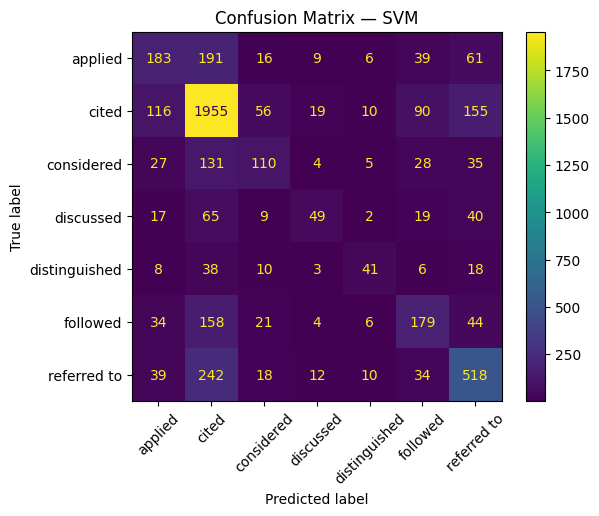


Top features for class 'applied':
W:at, W:Spassked, W:Roper, W:167, C:. 2, W:Data, W:explained, W:Ground, W:19 The, W:card, W:like the, W:am, W:now, W:as trade, W:However that

Top features for class 'cited':
W:In the, C: ( , W:Court as, W:appeal to, W:There is, W:Pharmaceuticals 2006, W:for decision, W:case to, W:long, W:applicant to, W:learned Federal, W:AWB, W:Form, W:her Honour, W:in this

Top features for class 'considered':
W:Mr Hicks, W:Hicks, W:pooling, W:decision in, W:the hearing, W:observes, W:of credit, W:observes that, W:Farmlink, W:insured, W:Court observes, W:considered on, W:member, W:FMG, W:QWI

Top features for class 'discussed':
W:rent, C:): ", W:ship, C:: ", W:the summons, W:Pearl Coast, W:certain, W:issue, W:10, W:Khawar, W:amalgamation, W:well, W:the children, W:588M, W:but for

Top features for class 'distinguished':
W:distinguishable, W:is distinguishable, W:relied, W:case, W:the present, W:was, W:Ms Le, W:initial statement, W:that case, W:the creditor, W:prese

In [ ]:
import numpy as np   # numpy fast arrays
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix  # ConfusionMatrixDisplay confusion_matrix equalls stuff to make and show a confusion matrix

# Refit SVM on train and val
trval_text = train_df["text"].tolist() + val_df["text"].tolist()   # this make one list of texts and  TRAIN texts and VALIDATION texts
trval_label = train_df["label"].tolist() + val_df["label"].tolist()    # make one list of labels TRAIN labels and VALIDATION labels

svm_best.fit(trval_text, trval_label)   # it trains the best SVM again on all train and val data
y_test_pred_svm = svm_best.predict(X_test)  # it uses that SVM to predict labels for the TEST texts

print("\n=== Test — TF–IDF + LinearSVC ===")   # it print a header line
print("Accuracy:", accuracy_score(y_test, y_test_pred_svm))   # this print test Accuracy how many correct overall
print("Macro-F1:", f1_score(y_test, y_test_pred_svm, average="macro"))    # it print test Macro-F1 average F1 over all labels and equal weight
print(classification_report(y_test, y_test_pred_svm))   # it print precision recall F1 for each label

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_svm, xticks_rotation=45)   # it draw the confusion matrix true vs predicted labels and rotate x-axis labels 45 degree so they are easier to read
plt.title("Confusion Matrix — SVM")
plt.show()    # it set a title and show the plot

# Top n-grams per class
def top_ngrams_per_class(pipe, n=15):    # it get the TF–IDF feature maker from this
    vec = pipe.named_steps["vec"]   # get the SVM model
    clf = pipe.named_steps["clf"]

    word_names = vec.transformer_list[0][1].get_feature_names_out()    # it get all WORD n-gram feature names
    char_names = vec.transformer_list[1][1].get_feature_names_out()  # get all CHAR n-gram feature name
    word_names = [f"W:{w}" for w in word_names]
    char_names = [f"C:{c}" for c in char_names]    # it add a tag so we know which are words W: and which are chars C:
    feature_names = np.concatenate([word_names, char_names])

    coefs = clf.coef_      # the SVM weights for each class bigger weight equalls more important feature
    classes = clf.classes_    # the class names labels in the same order as coefs rows
    tops = {}
    for i, cls in enumerate(classes):
        top_idx = np.argsort(coefs[i])[-n:][::-1]   # it find the indexes of the top n biggest weights for this class
        tops[cls] = [feature_names[j] for j in top_idx]    # -n: takes the largest n ::-1 flips to descending
    return tops    # return a dictionary class list of top features

tops = top_ngrams_per_class(svm_best, 15)   # it get the top 15 features for each class from the trained SVm
for cls, feats in tops.items():
    print(f"\nTop features for class '{cls}':")
    print(", ".join(feats))   # it prints the class name and its top n-grams most helpful features


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Batches:   0%|          | 0/20 [00:00<?, ?it/s]


=== Test — Embeddings + Logistic Regression ===
Accuracy: 0.4850715746421268
Macro-F1: 0.12515680895342857
               precision    recall  f1-score   support

      applied       0.18      0.01      0.02       505
        cited       0.50      0.95      0.66      2401
   considered       0.17      0.01      0.03       340
    discussed       0.30      0.01      0.03       201
distinguished       0.00      0.00      0.00       124
     followed       0.14      0.01      0.01       446
  referred to       0.32      0.08      0.13       873

     accuracy                           0.49      4890
    macro avg       0.23      0.15      0.13      4890
 weighted avg       0.36      0.49      0.35      4890



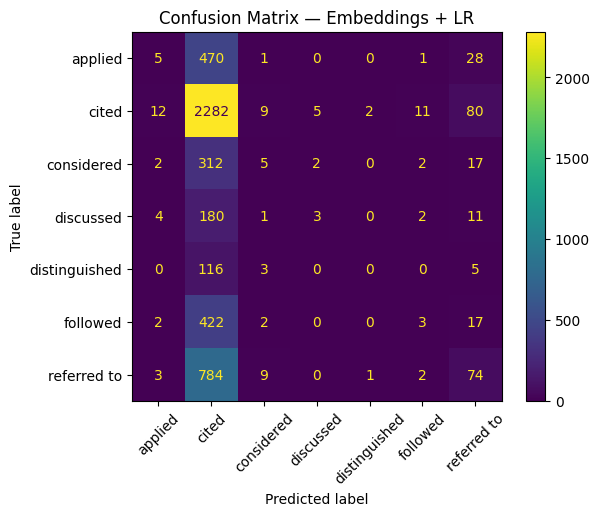

In [ ]:
# Embedding Logistic Regression test evaluation
if USE_ST:     # it only run if sentence embeddings are available
    trval_text_all = trval_text      # it takes all trainvalidation texts and turn those texts into embedding vectors
    X_trval_emb = embed(trval_text_all)    # it turns those texts into embedding vectors
    lr_best.fit(X_trval_emb, trval_label)   # train the best LR model on train and val vectors and labels

    X_test_emb = embed(X_test)  # re-embed the test and make embeddings for the test texts vectors
    y_test_pred_lr = lr_best.predict(X_test_emb)     # it get predicted labels on the test set

    print("\n=== Test — Embeddings + Logistic Regression ===")   # it header line for clarity
    print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))   # this print test accuracy
    print("Macro-F1:", f1_score(y_test, y_test_pred_lr, average="macro"))    # it print test macro-F1
    print(classification_report(y_test, y_test_pred_lr))    # it print per-class precision recall F1

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_lr, xticks_rotation=45)    # it draws the confusion matrix true vs predicted and rotate x-axis labels by 45 degrees so they are easier to read
    plt.title("Confusion Matrix — Embeddings + LR")   # it set a title for the plot
    plt.show()    # it show the plot
else:
    print("Skipped Pipeline B (no embeddings).")     # if embeddings not available it skip and tell the user
